# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [39]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>%
    group_by(character, episode_number) %>%
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>%
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

In [40]:
library(tidyverse)

## Question 1
In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

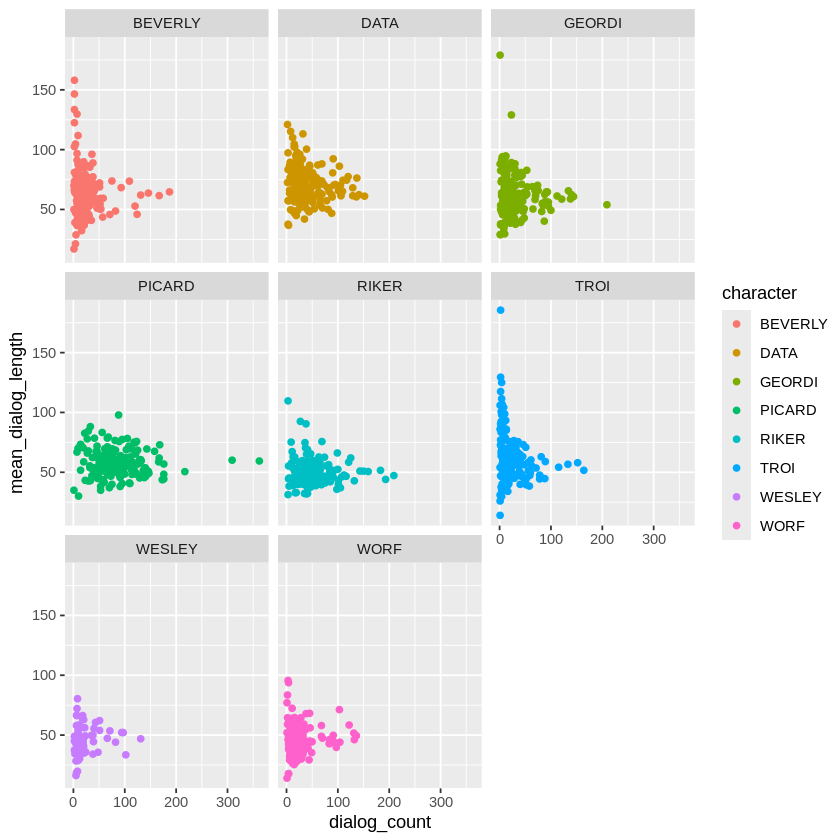

In [41]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) +
    geom_point(aes(color=character)) +
    facet_wrap(~character)

We can identify each character's role by examining the shape and position of their dialogue cloud. In the above visualizations, the x-axis represents number of lines a character has and the y-axis represents mean dialogue length per episode. This means that characters whose points cluster towards the right and higher up in the graph are main characters who get more dialogues. While plots where characters have medium dialogue counts and lower mean dialogue counts could be supporting characters with a decent ammount of dialogue. The minor characters would be those who have low dialogue count and low dialogue length.

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`.
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season.

In [42]:
beverly_dialog <- dialog_len_per_ep |>
  filter(character == "BEVERLY",
          episode_number >= 102,
          episode_number <= 174) |>
  mutate(season = case_when(
         episode_number <= 126 ~ "S1",
         episode_number >= 149 ~ "S3",
         TRUE ~ NA_character_)) |>
  filter(!is.na(season))


beverly_means <- beverly_dialog |>
  group_by(season, episode_number) |>
  summarise(
        dialog_count = sum(dialog_count),
        mean_len = mean(mean_dialog_length),
        .groups = "drop"
  )


mean_tb <- beverly_means |>
  group_by(season) |>
  summarise(
        mean_dialog_length = mean(mean_len),
        mean_dialog_count = mean(dialog_count),
        .groups = "drop"
  )

print(mean_tb)

# A tibble: 2 × 3
  season mean_dialog_length mean_dialog_count
  <chr>               <dbl>             <dbl>
1 S1                   56.5              25.4
2 S3                   67.0              19.6


#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

Looking at the graph from Question 1, it is not clear what the effect of being fired and rehired was on her storyline. However, looking at the graph, we can see a wide spread in terms of mean dialogue length. In the table from Question 2a, we can see that her mean dialogue count went down from 25.4 in Season 1 to 19.6 in Season 3. However, Beverly's dialogue length went up from 56.5 in Season 1 to 67.0 in Season 3. Perhaps, her male character-esque storyline is reflected by having longer dialogue as they may have been more monologue-esque or substantial and more relevant to the plot.

## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character.
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [43]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

In [44]:
tokens_dialogue <- dialogs_fixed |>
  mutate(word_list = str_split(dialog, "\\s+")) |>
  unnest(word_list) |>
  mutate(
        word = str_remove_all(word_list, "[[:punct:]]"),
        word = str_to_lower(word)
  ) |>
  filter(word != "", !word %in% stop_words) |>
  select(character, word)

head(tokens_dialogue, 10)

character,word
<chr>,<chr>
PICARD,captains
PICARD,log
PICARD,stardate
PICARD,423537
PICARD,destination
PICARD,planet
PICARD,cygnus
PICARD,iv
PICARD,beyond


#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [45]:
vocab_rich_tb <- tokens_dialogue |>
  group_by(character) |>
  summarise(
        total_words = n(),
        unqiue_words = n_distinct(word),
        vocab_rich = unqiue_words / total_words,
        .groups = "drop"
  ) |>
    arrange(desc(vocab_rich))

print(vocab_rich_tb)

# A tibble: 8 × 4
  character total_words unqiue_words vocab_rich
  <chr>           <int>        <int>      <dbl>
1 WESLEY           7601         2291      0.301
2 WORF            18820         4318      0.229
3 TROI            19450         4187      0.215
4 BEVERLY         22900         4875      0.213
5 DATA            45462         8593      0.189
6 GEORDI          31978         5465      0.171
7 RIKER           41827         6458      0.154
8 PICARD          79214         9272      0.117


#### c) Plot total words versus vocab richness.
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

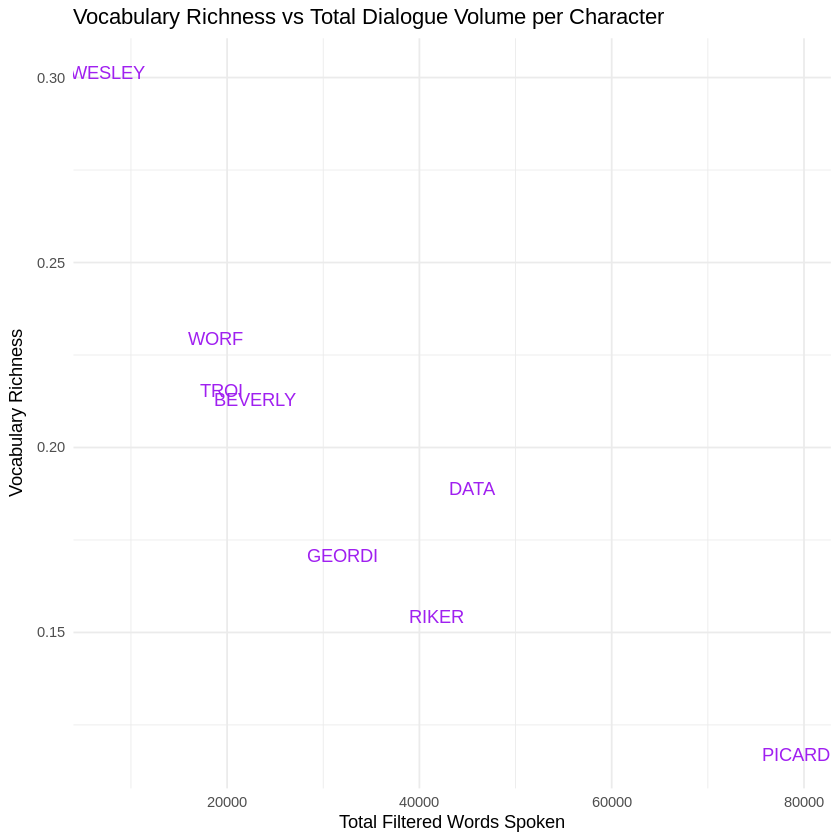

In [46]:
ggplot(vocab_rich_tb,
  mapping = aes(x = total_words, y = vocab_rich, label = character)) +
  geom_text(color = "purple") +
  labs(
      title = "Vocabulary Richness vs Total Dialogue Volume per Character",
      x = "Total Filtered Words Spoken",
      y = "Vocabulary Richness"
  ) + theme_minimal()

#### d) Interpret these results.

The graph shows a inverse relationship and strong negative correlation between spoken words and vocabulary richness. The characters who speak more (as seen in the graph from Question 1) have lower vocabulary richness which may be due to having catchphrases or other repetitive vernacular (ex: Pickard). However, some characters who speak less have higher vocabulary richness (ex: Weslesy and Worf), since their limited lines may not contain as much repetitive content.

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row.
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap.

In [47]:
wesley_counts <- dialogs_fixed |>
  filter(character == "WESLEY", episode_number > 174) |>
  group_by(episode_number) |>
  summarise(dialog_count = n(), .groups = "drop")

print(wesley_counts)

# A tibble: 11 × 2
   episode_number dialog_count
            <dbl>        <int>
 1            175           18
 2            176            6
 3            177            9
 4            178            6
 5            179           38
 6            181            2
 7            183           94
 8            206          131
 9            219           71
10            263           18
11            272           97


Based on the output, Wesley left the show as a main character after episode 183.

#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?

After Wesley leaves the main cast, he makes cameo appearances in the episodes 206, 219, 263, and 272.

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

In [48]:
wesley_before_dept <- dialogs_fixed |>
  filter(character == "WESLEY", episode_number <= 183) |>
  slice_tail(n = 1) |>
  select(episode_number, dialog)

wesley_last_dialog <- dialogs_fixed |>
  filter(character == "WESLEY") |>
  slice_tail(n = 1) |>
  select(episode_number, dialog)

print(wesley_before_dept)
print(wesley_last_dialog)

# A tibble: 1 × 2
  episode_number dialog     
           <dbl> <chr>      
1            183 I can walk.
# A tibble: 1 × 2
  episode_number dialog        
           <dbl> <chr>         
1            272 Good-bye, Mom.


## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title.
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

In [49]:
# set up
char_order <- dialog_len_per_ep |>
  group_by(character) |>
  summarise(
        overall_mean = mean(mean_dialog_length),
        .groups = "drop"
  ) |>
    arrange(overall_mean) |>
    pull(character)

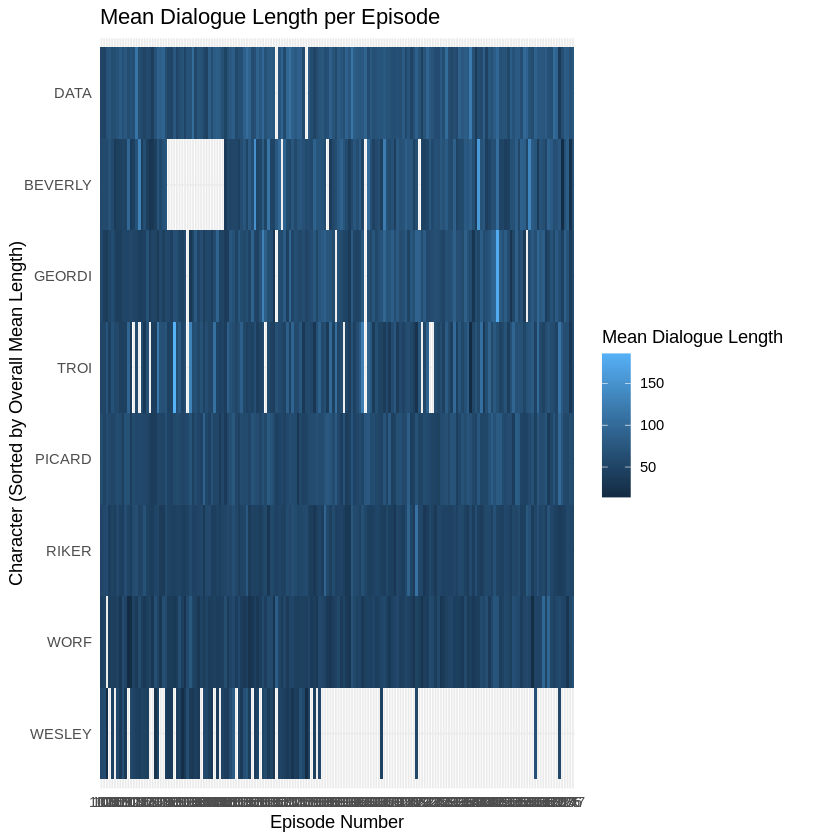

In [50]:
# heatmap
ggplot(dialog_len_per_ep,
  mapping = aes(x = factor(episode_number), y = factor(character, levels = char_order))) +
    geom_tile(mapping = aes(fill = mean_dialog_length)) +
    labs(
      title = "Mean Dialogue Length per Episode",
      x = "Episode Number",
      y = "Character (Sorted by Overall Mean Length)",
      fill = "Mean Dialogue Length"
    ) + theme_minimal()